In [35]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

#create database
agg_match_db = create_engine('sqlite:///agg_match.db')
chunksize_ = 200000
files = ['agg_match_stats_0.csv', 'agg_match_stats_1.csv',
         'agg_match_stats_2.csv', 'agg_match_stats_3.csv',
         'agg_match_stats_4.csv']
for file in files:
    for df in pd.read_csv(file, chunksize = chunksize_, iterator = True):
        #data cleanning
        columns = ['match_id','match_mode', 'party_size', 'player_name',
                   'team_id', 'team_placement', 'player_kills', 'player_dbno', 
                   'player_assists', 'player_dmg','player_dist_ride', 'player_dist_walk']
        for c in df.columns:
            if c not in columns:
                df = df.drop(c, axis=1)
        df = df.dropna()
        df = df[df.party_size == 1]
        df = df[df.player_dist_walk != 0]
        df['total_dist'] = df['player_dist_ride']+ df['player_dist_walk']
        df.to_sql('amatch_solo', agg_match_db, if_exists='append')



In [39]:
df1 = pd.read_sql_query('select total_dist from amatch_solo', agg_match_db)

total_dist    185.137909
Name: 0.25, dtype: float64

In [53]:
Q1 = df1.quantile(q=0.25)
Q3 = df1.quantile(q=0.75)
IQR = Q3 - Q1
print(IQR)
print("[%f,%f]"%(0, Q3 + 1.5*IQR))

total_dist    3277.093366
dtype: float64
[0.000000,8377.871324]


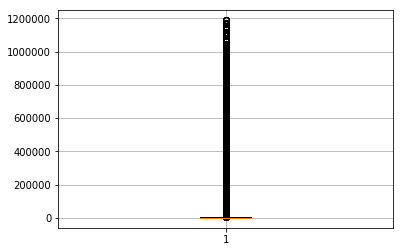

In [50]:
import matplotlib.pylab as plt

plt.boxplot(df1['total_dist'])
plt.show()

In [55]:
df2 = pd.read_sql_query('select * from amatch_solo where total_dist < 8400', agg_match_db)

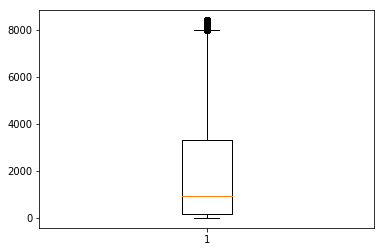

In [56]:
plt.boxplot(df2['total_dist'])
plt.show()

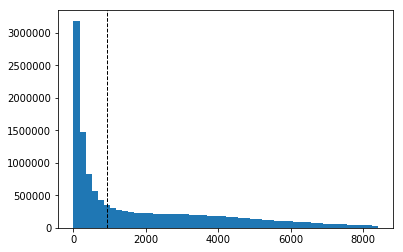

In [60]:
plt.hist(df2['total_dist'], bins= 50)
plt.axvline(df2['total_dist'].median(), color='k', linestyle='dashed', linewidth=1)
plt.show()

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sqlalchemy import create_engine
agg_match_db = create_engine('sqlite:///agg_match.db')
df3 = pd.read_sql_query('select match_id, player_kills, player_dbno, player_assists, total_dist, team_placement from amatch_solo where total_dist < 8400 and team_placement < 70 group by match_id', agg_match_db)

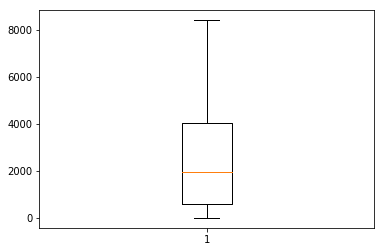

570.869684


In [77]:
fig, ax = plt.subplot()
plt.boxplot(df3['total_dist'], ax=ax)
ax.set_ylabel("Total Travel Distance (m)", fontsize=18)
plt.show()
q1 = df3['total_dist'].quantile(0.25)
print(q1)

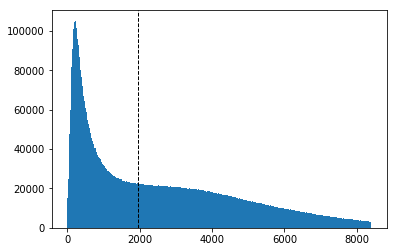

In [71]:
plt.hist(df3['total_dist'], bins= 500)
plt.axvline(df3['total_dist'].median(), color='k', linestyle='dashed', linewidth=1)
plt.show()

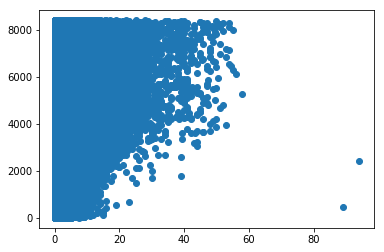

In [79]:
df3['skill'] = df3['player_kills']+df3['player_dbno']+0.5*df3['player_assists']
plt.scatter(df3['skill'], df3['total_dist'])
plt.show()

In [12]:
df3['skill'] = df3['player_kills']+df3['player_dbno']+0.5*df3['player_assists']
df3['final_score'] = 0.5*df3['total_dist']/(df3['total_dist'].median())+0.5*df3['skill']/(df3['skill'].median())

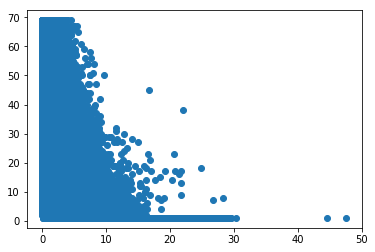

In [16]:
#fig, ax = plt.subplot(figsize=(20,20))
plt.scatter(df3['final_score'], df3['team_placement'])
plt.show()

In [21]:
match_ids = pd.read_sql_query('select distinct match_id from amatch_solo', agg_match_db)
print(match_ids)

                                                 match_id
0       2U4GBNA0YmlixJ6lhgS6xB2tqdo7SEhoYyHlVu18akkAzL...
1       2U4GBNA0YmnMiL8FxzK-xRalmDs8__VvvNzmntjlIzBi0D...
2       2U4GBNA0YmnNOKktVk9Qv5ZxUnnxXk1-kUI03yF8vbYyzd...
3       2U4GBNA0YmmyNWABCuuEotdFnf2pYAu3C5f-JJ9Qv-UyQV...
4       2U4GBNA0YmkRFnEnlar5FbJrM9fzxmAkpXnhkbdlw89MM6...
5       2U4GBNA0YmlcJd06MAp1d4Q7M5Yy4PYrahIr2JBT9uhhXk...
6       2U4GBNA0Ymm4vcRsQ1DQDPbaiK6c_0jM8aQ2SVRHMnNGFJ...
7       2U4GBNA0Ymm_5InGu4XxmbWrPJjpsdwDKldtKteYWNAiZw...
8       2U4GBNA0YmkbaxRIRrLkucLQeELe8PYIRW3ZTi14fb52We...
9       2U4GBNA0YmkvCmIao1jSik4oZSUnd8bzeMgA1H7GSnDkUa...
10      2U4GBNA0Ymk9oWjnPmYXWVwfOe3D-owgLcMqizYDazwhqu...
11      2U4GBNA0Ymmc9iQSXPdXmsArOhTIR61JwcNH4n6Z2nEAsP...
12      2U4GBNA0Ymk5zg3inVCasHGfBCqqK5ua4SpK2lrZRn20Eh...
13      2U4GBNA0YmmJfFpXZ-QZQs8br_sVYD6XGe3CDoGgnAM66k...
14      2U4GBNA0Ymnp7WwAto9g2slLUaiBKUFaPfS2cP7mxfvB4z...
15      2U4GBNA0YmkBdWOTl0viZyP9BZHq6-ofZRBEjZ_gLlyDDS...
16      2U4GBN

In [ ]:
total_dist_sum = []
final_score_sum = []
total_sum = 0
final_sum = 0
for i in range(len(match_ids)):
    j = match_ids.loc[i, 'match_id']
    hold_match = df3[df3.match_id == j]
    total_sum = hold_match['total_dist'].sum()
    final_sum = hold_match['final_score'].sum()
    total_dist_sum.append((j, total_sum))
    final_score_sum.append((j, final_sum))
    total_sum = 0
    final_sum = 0

In [ ]:
for i in df3.iterrows():
    if df3.loc[i, 'match_id'] == :
        print('here')